***Description***

This notebook consists of two parts:
1. Exploring keywords appeared in the corpus. I report the top keywords in the field *Descriptors* and *General Online Descriptors* where the keywords for each topic is selected from, which would play roles on choosing keywords for each topic
2. Exploring words and counts, as well as the word difference, for news articles and editorials.
3. Exploring numbers of words and sentences in each articles, which would play role on padding for RNN models.
4. Exploring discourse structures of the articles in NYTAC, namely, the average occurance of argumentation features, sentiment, and POS in news vs editorial, and normalized-timed occurance of those features.

In [1]:
# import libraries
from ast import literal_eval
import operator
import os
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from operator import itemgetter
from statistics import median, mean, quantiles
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/rldall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data for 1. and 2.

In [2]:
# import data
# specify required fields
fields = ['Body', 'Descriptors', 'General Online Descriptors', 'Lead Paragraph',
          'News Desk', 'Online Section', 'Types Of Material','Word Count']

# interested materials
material_list = ['editorial','op-ed','letter', 'none']

# filter for interested topics
key_dict = {
    'law' : ['law','right','court'],
    'politics' : ['politics','relation','international','regional'],
    'medicine' : ['medicine','health','disease'],
    'finance' : ['finances','business'],
    'military' : ['defense','armament','military'],
    'education' : ['education','school','teacher']
}

# select lists of keywords
l = [key_dict.get(k) for k in list(key_dict)]
flatten_l = [item for sublist in l for item in sublist]

# column used for filtering
filter_col = 'Descriptors'
s = '|'.join([item for item in flatten_l])

# import data
# train and val data
df1 = pd.read_csv('/data/RAW/nyt1996.csv',encoding='latin-1',usecols=fields)
df2 = pd.read_csv('/data/RAW/nyt2005.csv',encoding='latin-1',usecols=fields)
train_df = pd.concat([df1,df2])

# test data
test_df = pd.read_csv('/data/RAW/nyt1986.csv',encoding='latin-1',usecols=fields)

all_df = pd.concat([train_df, test_df])

## 1. Explore keywords in Descriptors/General Online Descriptors

In [3]:
# lowercase columns
for col in all_df.columns:
    if col not in ['Body', 'Word Count']:
        all_df[col] = all_df[col].str.lower()

In [4]:
# checking keywords

def check_keywords(df,top):
    des = []
    genondes = []
    for _, row in df.iterrows():
        s_des = row['Descriptors']
        s_genondes = row['General Online Descriptors']

        if type(s_des) == str:
            des.extend(s_des.split(sep='|'))
        if type(s_genondes) == str:
            genondes.extend(s_genondes.split(sep='|'))
            
    d_des = OrderedDict(sorted(Counter(des).items(), key = itemgetter(1), reverse = True))
    d_genondes = OrderedDict(sorted(Counter(genondes).items(), key = itemgetter(1), reverse = True))
    print ('No. of Descriptors:',len(d_des))
    print ('Top {} Descriptors: {}\n'.format(top,list(d_des)[:top]))
    print ('\nNo. of General Online Descriptors:',len(d_genondes))
    print ('Top {} General Online Descriptors: {}\n'.format(top, list(d_genondes)[:top]))
    return d_des, d_genondes

In [5]:
descript,gen_descript = check_keywords(all_df,30)

No. of Descriptors: 8236
Top 30 Descriptors: ['reviews', 'biographical information', 'company reports', 'music', 'television', 'united states international relations', 'finances', 'mergers, acquisitions and divestitures', 'books and literature', 'motion pictures', 'politics and government', 'elections', 'weddings and engagements', 'no index terms from nytimes', 'no index terms', 'correction stories', 'baseball', 'law and legislation', 'basketball', 'united states armament and defense', 'football', 'labor', 'presidential election of 1996', 'editorials', 'deaths', 'education and schools', 'ethics', 'terrorism', 'theater', 'travel and vacations']


No. of General Online Descriptors: 1586
Top 30 General Online Descriptors: ['politics and government', 'finances', 'united states politics and government', 'united states international relations', 'elections', 'presidential elections (us)', 'medicine and health', 'music', 'corporations', 'books and literature', 'presidential election of 1996', 

In [6]:
print (descript)

OrderedDict([('reviews', 10119), ('biographical information', 6946), ('company reports', 5339), ('music', 4801), ('television', 4414), ('united states international relations', 4264), ('finances', 4172), ('mergers, acquisitions and divestitures', 4153), ('books and literature', 4100), ('motion pictures', 3966), ('politics and government', 3864), ('elections', 3819), ('weddings and engagements', 3705), ('no index terms from nytimes', 3643), ('no index terms', 3591), ('correction stories', 3541), ('baseball', 3376), ('law and legislation', 3338), ('basketball', 3326), ('united states armament and defense', 2943), ('football', 2898), ('labor', 2764), ('presidential election of 1996', 2704), ('editorials', 2689), ('deaths', 2677), ('education and schools', 2657), ('ethics', 2635), ('terrorism', 2627), ('theater', 2560), ('travel and vacations', 2456), ('art', 2451), ('children and youth', 2407), ('housing', 2354), ('airlines and airplanes', 2291), ('stocks and bonds', 2282), ('murders and 

In [7]:
print (gen_descript)

OrderedDict([('politics and government', 20149), ('finances', 15466), ('united states politics and government', 9635), ('united states international relations', 9206), ('elections', 8032), ('presidential elections (us)', 7476), ('medicine and health', 7195), ('music', 6264), ('corporations', 6257), ('books and literature', 5735), ('presidential election of 1996', 5518), ('international relations', 5511), ('company reports', 5501), ('armament, defense and military forces', 5065), ('baseball', 4945), ('law and legislation', 4789), ('education and schools', 4700), ('television', 4662), ('mergers, acquisitions and divestitures', 4404), ('labor', 4375), ('motion pictures', 4197), ('computers and the internet', 4089), ('presidents and presidency (us)', 3860), ('weddings and engagements', 3779), ('basketball', 3712), ('crime and criminals', 3425), ('football', 3377), ('travel and vacations', 3367), ('united states armament and defense', 3345), ('terrorism', 3331), ('children and youth', 3136)

## 2. Exploring Words in relation to subjectivity

In [8]:
# Helper functions to count keywords in each type of material

def word_count(str):
    counts = dict()
    words = str.split()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

def get_words_dict(df):
    dict_list = []
    #get dict for each row
    for t in df.iloc[:,0].values:
        t = t.lower()
        art_dict = [{k:v} for k,v in word_count(t).items() if k not in list(stops)]
        dict_list.append(art_dict)
    # sum dicts from all rows
    word_dict = sum(
        (Counter(dict(x[0])) for x in dict_list),
        Counter())
    #sort and return
    return sort_return(word_dict)

def sort_return(word_dict):
    return dict(sorted(word_dict.items(), key = lambda x: x[1], reverse = True))

In [9]:
# fill NaN value with 'None'
all_df = all_df.fillna('None')

# transform Types Of Material
all_df.loc[all_df["Types Of Material"] == 'letter', "Types Of Material"] = 'editorial'
all_df.loc[all_df["Types Of Material"] == 'op-ed', "Types Of Material"] = 'editorial'
all_df.loc[all_df["Types Of Material"] == 'None', "Types Of Material"] = 'news'

In [11]:
# split dataframe
news_df = all_df[all_df['Types Of Material'] == 'news']
edit_df = all_df[all_df['Types Of Material'] == 'editorial']

# get keywords and counts
news_words = get_words_dict(news_df)
edit_words = get_words_dict(edit_df)

# print results: top 20 words
print('Top 20 words appeared in news articles are:\n'+', '.join(list(news_words)[:20]))
print('\nTop 20 words appeared in editorials are:\n'+', '.join(list(edit_words)[:20]))

# print results: no. of difference words in each type of material
print('\nThere are {} words that appear in news articles, but not in editorials'\
      .format(len(set(news_words)-set(edit_words))))
print('There are {} words that appear in editorials but not in news articles'\
      .format(len(set(edit_words)-set(news_words))))

# save results: show different words and counts in each type of material
ne_result = [(i,news_words.get(i)) for i in list(set(news_words)-set(edit_words))]
en_result = [(i,edit_words.get(i)) for i in list(set(edit_words)-set(news_words))]

Top 20 words appeared in news articles are:
lead:, new, one, two, president, federal, last, dr., united, first, state, american, mayor, police, city, dollar, three, house, like, yankees

Top 20 words appeared in editorials are:
editor:, lead:, new, sports, president, one, last, united, bob, long, two, bush, people, many, house, state, home, congress, american, mayor

There are 17881 words that appear in news articles, but not in editorials
There are 815 words that appear in editorials but not in news articles


In [12]:
print('Words, which appears in news articles, but not in editorials, and their count')
sort_return(dict(ne_result))

Words, which appears in news articles, but not in editorials, and their count


{'dollar': 1152,
 'yankees': 915,
 'giants': 685,
 'ford': 541,
 'knicks': 519,
 'nets': 500,
 'shares': 479,
 'jets': 413,
 'fire': 406,
 'pope': 396,
 'french': 383,
 'stocks': 381,
 'prices': 370,
 'google': 324,
 'st.': 318,
 'morgan': 315,
 'lawyers': 278,
 'at&t': 273,
 '*': 268,
 'rangers': 260,
 'boston': 259,
 'texas': 258,
 'oil': 257,
 'fidelity': 248,
 'university': 227,
 'red': 224,
 'delta': 220,
 'german': 219,
 'cbs': 219,
 'bank': 216,
 'iran': 213,
 'senior': 207,
 'boeing': 205,
 'investigators': 205,
 'verizon': 204,
 'i.b.m.': 196,
 'devils': 195,
 'sales': 192,
 'music': 191,
 'wal-mart': 190,
 'union': 183,
 'sun': 170,
 'golf': 163,
 'bronx': 161,
 'sir': 160,
 'amtrak': 159,
 'hedge': 157,
 'water': 156,
 'prosecutors': 151,
 'joe': 150,
 'orders': 150,
 'jennifer': 149,
 'game': 149,
 'security': 148,
 'guidant': 148,
 'suicide': 145,
 'mutual': 145,
 'los': 140,
 'tom': 137,
 'swiss': 135,
 'hong': 132,
 'researchers': 130,
 'wheat': 130,
 'suge': 129,
 'muse

In [13]:
print('Words, which appears in editorials but not in news articles, and their count')
sort_return(dict(en_result))

Words, which appears in editorials but not in news articles, and their count


{'knitting': 18,
 'bloggers': 13,
 'burgville': 10,
 'bibi': 10,
 'stunt': 10,
 'roberts': 9,
 'same-sex': 9,
 'infections': 9,
 'cato': 9,
 'census': 8,
 'thurow': 8,
 'files': 8,
 'heckscher': 8,
 'soda': 8,
 "green's": 7,
 'angolan': 7,
 'environmentalists': 7,
 'doctrine': 6,
 'cornelius': 6,
 'photos': 6,
 'editor;': 6,
 'ethicist': 6,
 'commit': 6,
 'strom': 6,
 'kitty': 6,
 'polo': 5,
 "''o": 5,
 'clintons': 5,
 'uganda': 5,
 'applaud': 5,
 'acquittal': 5,
 'styles': 5,
 'secrecy': 5,
 'dictatorship': 4,
 '17th-century': 4,
 'ethanol,': 4,
 'cloning': 4,
 'polar': 4,
 'eastchester': 4,
 'scooter': 4,
 'merkin': 4,
 'editors:': 4,
 'delighted': 4,
 'dentist-anesthesiologists': 4,
 'nicaragua': 4,
 'pluto': 4,
 'scorpion': 3,
 'kluger': 3,
 'morality': 3,
 'rosen': 3,
 'nguyen': 3,
 'bosnia': 3,
 'post-election': 3,
 'ierney': 3,
 "feldman's": 3,
 'doctor,': 3,
 'editor,': 3,
 'ugly': 3,
 '"of': 3,
 "''october": 3,
 'dowd': 3,
 'terror': 3,
 'visited': 3,
 'me,': 3,
 'all-voluntee

## Import data for 3. and 4.

In [2]:
# Helper function to import data
def select_files(path, startwith):
    list_of_files = []
    files = os.listdir(path)
    for file in files:
        if file.startswith(startwith):
            list_of_files.append(str(path)+str(file))
    return list_of_files

In [3]:
# import data
list_of_files = select_files('/data/ProcessedNYT/','all')

list_of_dfs = []
for file in list_of_files:
    df = pd.read_csv(file,sep='\t',header=None)
    list_of_dfs.append(df)

In [4]:
all_df = pd.concat(list_of_dfs)

## 3. Word-Sentence Statistics

In [5]:
# no. of sentences per article: min, max, avg
sent_p_art = [] 
# no. of sentences per article: min, max, avg
word_p_art = []
# no. words (pos) per sentence: min, max, avg 
word_p_sent = []

for idx,i in enumerate(all_df.iloc[:,1]):

    if (idx+1)%2000 == 0:
        print('finished analyzing {} articles'.format(idx+1))

    sent = sent_tokenize(i)
    sent_p_art.extend([len(sent)])    
    article = word_tokenize(i)
    word_p_art.extend([len(article)])
    for string in sent:
        words = word_tokenize(string)
        word_p_sent.extend([len(words)]) 

finished analyzing 2000 articles
finished analyzing 4000 articles
finished analyzing 6000 articles
finished analyzing 8000 articles
finished analyzing 10000 articles
finished analyzing 12000 articles
finished analyzing 14000 articles
finished analyzing 16000 articles
finished analyzing 18000 articles


In [7]:
# results   
print('No. of sentence per article:\n\t-max {}\n\t-mean {}\n\t-median {}'.\
     format(max(sent_p_art),mean(sent_p_art),median(sent_p_art)))
print('\t95% of articles contain equal or less than {} sentences'.format(np.percentile(sent_p_art, 95)))

print('No. of word per article:\n\t-max {}\n\t-mean {}\n\t-median {}'.\
     format(max(word_p_art),mean(word_p_art),median(word_p_art)))
print('\t95% of articles contain equal or less than {} words'.format(np.percentile(word_p_art, 95)))

print('No. of word per sentence:\n\t-max {}\n\t-mean {}\n\t-median {}'.\
     format(max(word_p_sent),mean(word_p_sent),median(word_p_sent)))
print('\t95% of sentences contain equal or less than {} words'.format(np.percentile(word_p_sent, 95)))

No. of sentence per article:
	-max 538
	-mean 29.636345105233655
	-median 26
	95% of articles contain equal or less than 68.0 sentences
No. of word per article:
	-max 10741
	-mean 749.6204963563166
	-median 692
	95% of articles contain equal or less than 1689.8999999999978 words
No. of word per sentence:
	-max 1283
	-mean 25.29419108113778
	-median 24.0
	95% of sentences contain equal or less than 49.0 words


### helper functions

In [5]:
# Helper function to get results

def get_features_result(df, col):

    news_count_dict_list = []
    edit_count_dict_list = []

    # iterate and count features in each row
    for _, row in df.iterrows():
        
        if col == 5:
            v = literal_eval(row[col])
            flatten = [item for sublist in v for item in sublist]
            art_count = Counter(flatten)
        else:
            art_count = Counter(literal_eval(row[col]))
            
        if row[0] == 0 : #row=label; news: 0
            news_count_dict_list.append(art_count)
        elif row[0] == 1 : #row=label; news: 0
            edit_count_dict_list.append(art_count)
        
    news_sum_count_dict = sum(news_count_dict_list, Counter())
    edit_sum_count_dict = sum(edit_count_dict_list, Counter())

    news_sum_pct_dict = {}
    edit_sum_pct_dict = {}

    # % of the features occured in dataset
    s = sum(news_sum_count_dict.values())
    for k, v in news_sum_count_dict.items():
        pct = v * 100.0 / s
        news_sum_pct_dict.update({k: round(pct,2)})
    
    # % of each type of argumentation in news article
    s = sum(edit_sum_count_dict.values())
    for k, v in edit_sum_count_dict.items():
        pct = v * 100.0 / s
        edit_sum_pct_dict.update({k: round(pct,2)})

    return news_sum_pct_dict, edit_sum_pct_dict

In [6]:
# normalized time % of features in news vs edit

def get_normalizetimed_result(df,col):

    timenorm_list = []

    for idx, row in df.iterrows():
        feat = literal_eval(row[col])
        sent_idx = list(np.round(np.linspace(0,len(feat)-1,100),0))
        normalize = [feat[int(n)] for n in sent_idx]
    
        normalize_row = [row[0]]+normalize
        timenorm_list.append(normalize_row)
        
    df_pos = pd.DataFrame(timenorm_list)
    df_pos_news = df_pos[df_pos[0]==0]
    df_pos_edit = df_pos[df_pos[0]==1]
    
    news_norm_dict = {}

    for col in df_pos_news.columns[1:]:
        count = df_pos_news[col].value_counts()
        count_dict = count.to_dict()
        s = sum(count_dict.values())
        for k, v in count_dict.items():
            pct = v * 100.0 / s
            count_dict.update({k:round(pct,2)})
        news_norm_dict.update({col:count_dict})
    
    edit_norm_dict = {}

    for col in df_pos_edit.columns[1:]:
        count = df_pos_edit[col].value_counts()
        count_dict = count.to_dict()
        s = sum(count_dict.values())
        for k, v in count_dict.items():
            pct = v * 100.0 / s
            count_dict.update({k:round(pct,2)})
        edit_norm_dict.update({col:count_dict})
        
    return pd.DataFrame(news_norm_dict), pd.DataFrame(edit_norm_dict)

In [12]:
def plot_normalized(df1,df2,title1,title2,legend=None,main_title=None,colors='bgrcmyk'):
    fig, axes = plt.subplots(ncols=2, figsize=(10,4))
    colors = colors
    
    df1t = df1.T
    df2t = df2.T   
    df1t = df1t[sorted(list(df1t.columns))]
    df2t = df2t[sorted(list(df1t.columns))]

    #df1t.plot(title=title1,ax=axes[0],color=colors,ylim=(0,100))
    #df2t.plot(title=title2,ax=axes[1],color=colors,ylim=(0,100))
    df1t.plot(title=title1,ax=axes[0], legend=None,color=colors,ylim=(0,100))
    df2t.plot(title=title2,ax=axes[1],legend=None,color=colors,ylim=(0,100))

    legend = legend
    fig.suptitle(main_title)
    fig.legend(legend, loc='center right',bbox_to_anchor=(1.2, 0.5),ncols=1)

    fig.tight_layout()
    plt.show()

In [10]:
def get_correlation(df, col):

    count_dict_list = []

    # iterate and count features in each row
    for _, row in df.iterrows():
        v = literal_eval(row[col])
        flatten = [item for sublist in v for item in sublist]
        art_count = Counter(flatten)
            
        if row[0] == 0 : #row=label; news: 0
            art_count.update({'y':0})
            count_dict_list.append(art_count)
        elif row[0] == 1 : #row=label; editorial: 1
            art_count.update({'y':1})
            count_dict_list.append(art_count)
        
    return count_dict_list

## 4.1 Argumentation Features

1. types/% of argfeat 3 and argfeat6 in news vs edit
2. normalized time % of subj and obj in news vs edit

In [20]:
# classes
# [1: 'claim', 2: 'non-argument', 3: 'premise']
news_af3_result, edit_af3_result = get_features_result(all_df, 6)

print('On average, news consist of {} % of premise, {} % of claims, and {} of non-argument features.'.\
      format(news_af3_result.get(3),news_af3_result.get(1),news_af3_result.get(2)))
print('On average, editorials consist of {} % of premise, {} % of claims, and {} of non-argument features.'.\
      format(edit_af3_result.get(3),edit_af3_result.get(1),edit_af3_result.get(2)))

On average, news consist of 70.96 % of premise, 28.67 % of claims, and 0.37 of non-argument features.
On average, editorials consist of 35.17 % of premise, 63.99 % of claims, and 0.84 of non-argument features.


In [26]:
# classes
# [1: 'anecdote', 2: 'assumption', 3: 'common-ground', 4: 'other', 5: 'statistics', 6: 'testimony']
news_af6_result, edit_af6_result = get_features_result(all_df, 7)

print('On average, news consist of {} % of assumptions, {} % of anedotes, {} % common-ground, {} % statistics,\
      {} % testimony, and {} % of non-argument features.'.\
      format(news_af6_result.get(2),news_af6_result.get(1),news_af6_result.get(3),\
             news_af6_result.get(5),news_af6_result.get(6),news_af6_result.get(4)))
print('On average, editorials consist of {} % of assumptions, {} % of anedotes, {} % common-ground, {} % statistics,\
      {} % testimony, and {} % of non-argument features.'.\
      format(edit_af6_result.get(2),edit_af6_result.get(1),edit_af6_result.get(3),\
             edit_af6_result.get(5),edit_af6_result.get(6),edit_af6_result.get(4)))

On average, news consist of 31.93 % of assumptions, 22.96 % of anedotes, 1.03 % common-ground, 3.34 % statistics,      39.62 % testimony, and 1.12 of non-argument features.
On average, editorials consist of 65.28 % of assumptions, 14.46 % of anedotes, 1.91 % common-ground, 2.08 % statistics,      11.86 % testimony, and 4.42 of non-argument features.


In [8]:
# classes
# [1: 'claim', 2: 'non-argument', 3: 'premise']
news_norm_af3_df, edit_norm_af3_df = get_normalizetimed_result(all_df,6)

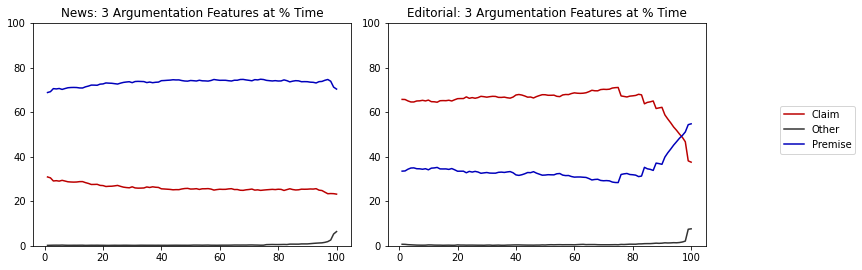

In [13]:
plot_normalized(news_norm_af3_df,edit_norm_af3_df,\
                'News: 3 Argumentation Features at % Time','Editorial: 3 Argumentation Features at % Time',\
                ["Claim",'Other', "Premise"],colors=['#BB0000','#333333','#0000BB'])

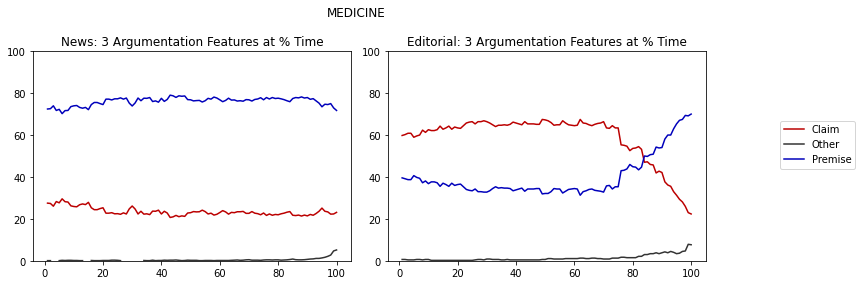

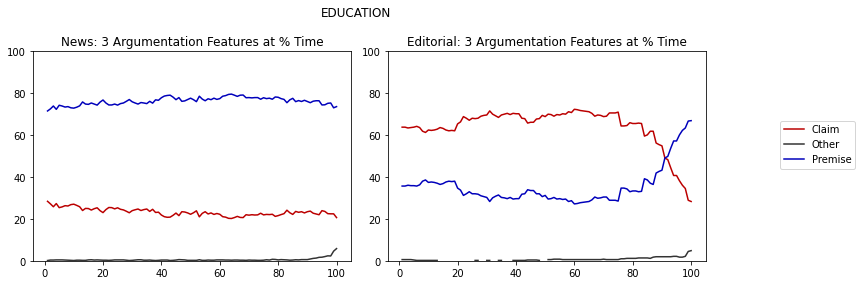

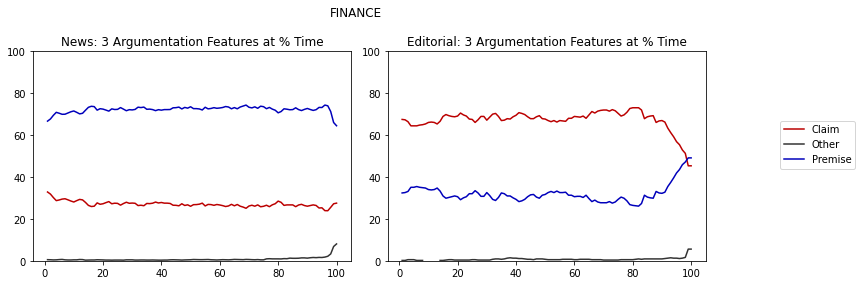

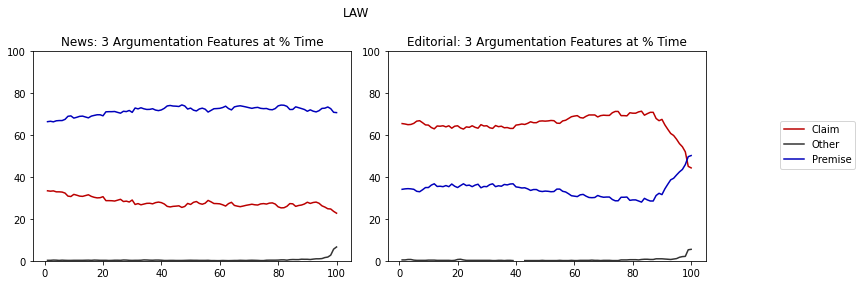

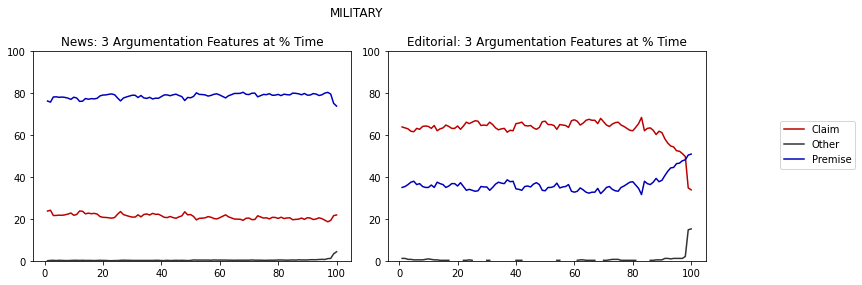

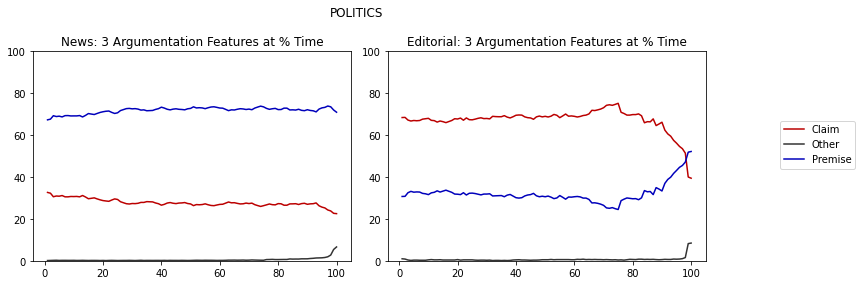

In [159]:
# report by genre
for idx,df in enumerate(list_of_dfs):
    
    filename = list_of_files[idx].split('_')[-1:]
    genre = filename[0].split('.')[0].upper()

    news_df, edit_df = get_normalizetimed_result(df,6)
    plot_normalized(news_df,edit_df,\
                'News: 3 Argumentation Features at % Time','Editorial: 3 Argumentation Features at % Time',\
                ["Claim",'Other', "Premise"],genre,['#BB0000','#333333','#0000BB'])

In [125]:
# classes
# [1: 'anecdote', 2: 'assumption', 3: 'common-ground', 4: 'other', 5: 'statistics', 6: 'testimony']
news_norm_af6_df, edit_norm_af6_df = get_normalizetimed_result(all_df,7)

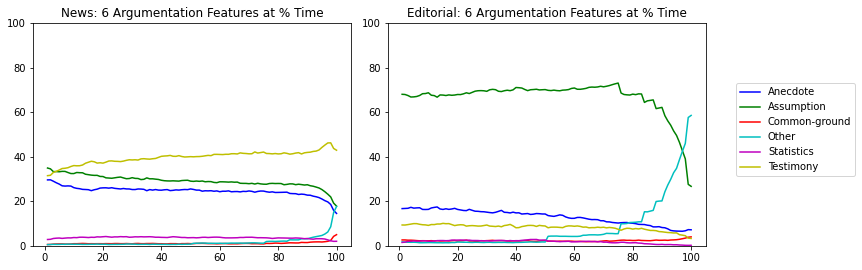

In [156]:
plot_normalized(news_norm_af6_df,edit_norm_af6_df,\
                'News: 6 Argumentation Features at % Time','Editorial: 6 Argumentation Features at % Time',\
                ['Anecdote',"Assumption",'Common-ground','Other','Statistics',"Testimony"])

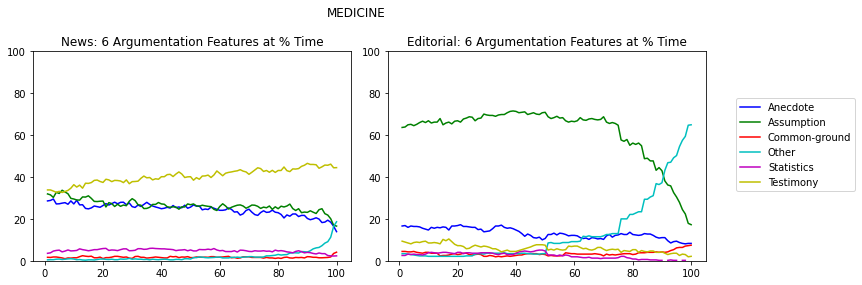

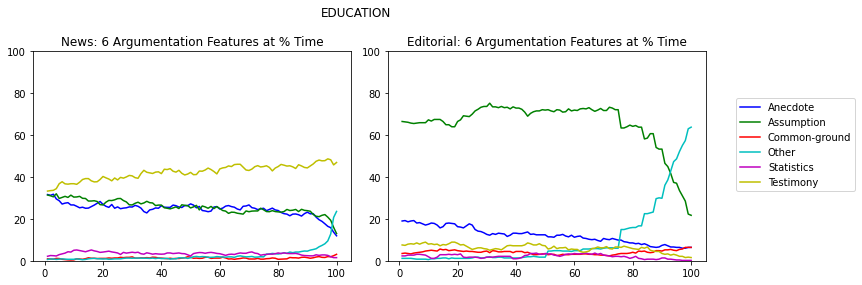

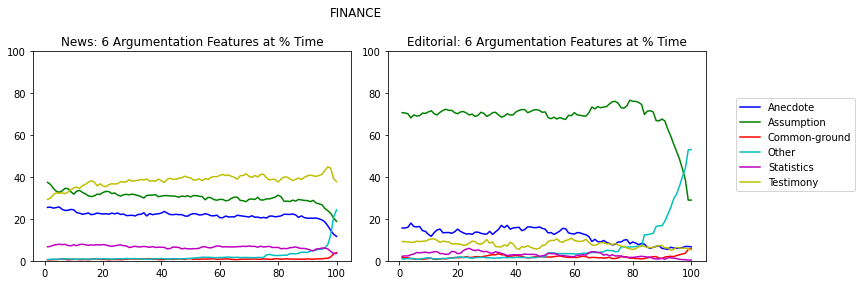

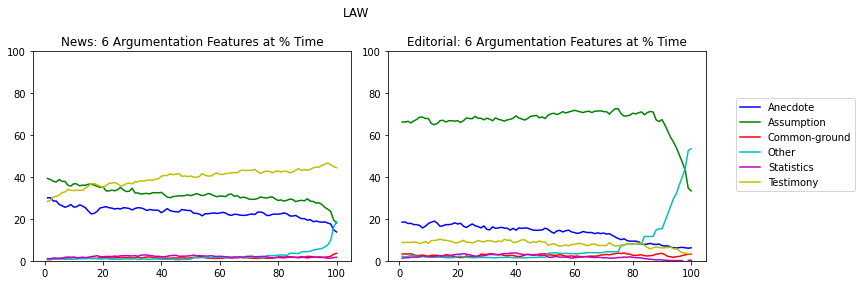

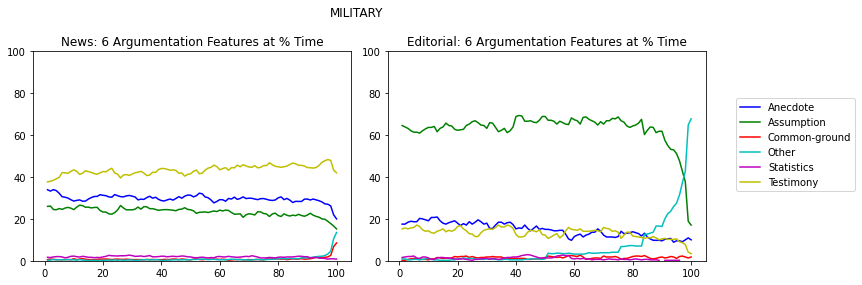

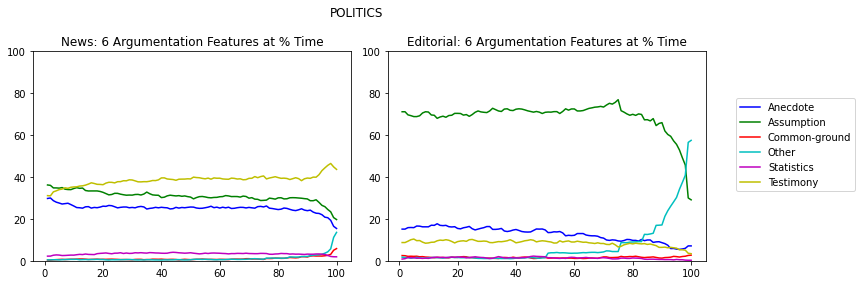

In [157]:
# report by genre
for idx,df in enumerate(list_of_dfs):
    
    filename = list_of_files[idx].split('_')[-1:]
    genre = filename[0].split('.')[0].upper()

    news_df, edit_df = get_normalizetimed_result(df,7)
    plot_normalized(news_df,edit_df,\
                'News: 6 Argumentation Features at % Time','Editorial: 6 Argumentation Features at % Time',\
                ['Anecdote',"Assumption",'Common-ground','Other','Statistics',"Testimony"],genre)

## 4.2 Sentiment Analysis

1. avg sentcom in news vs edit
2. avg % of sentsum in news vs edit
3. normalized time % of neutral vs non-neutral in news vs edit

In [41]:
# avg sentcom in news vs edit

news_sentcom = 0
news_count = 0
edit_sentcom = 0
edit_count = 0

for _,row in all_df.iterrows():
    v = literal_eval(row[3])
    avg = sum(v)/len(v)
    if row[0] == 0:
        news_sentcom += avg
        news_count +=1
    elif row[0] == 1:
        edit_sentcom += avg
        edit_count += 1
        
print('On average, news has the compound sentiment score of {}.'.format(news_sentcom/news_count))
print('On average, editorial has the compound sentiment score of {}.'.format(edit_sentcom/edit_count))

On average, news has the compound sentiment score of 0.020243639205884945.
On average, editorial has the compound sentiment score of 0.02957197317450447.


In [40]:
# classes
# [1: 'positive', 0: 'neutral', -1: 'negative']
news_sent_result, edit_sent_result = get_features_result(all_df, 4)

print('On average, news consist of {} % of neutral statement, {} % of positive statement, and {} % of negative statement.'.\
      format(news_sent_result.get(0),news_sent_result.get(1),news_sent_result.get(-1)))
print('On average, editorials consist of {} % of neutral statement, {} % of positive statement, and {} % of negative statement.'.\
      format(edit_sent_result.get(0),edit_sent_result.get(1),edit_sent_result.get(-1)))

On average, news consist of 34.51 % of neutral statement, 35.75 % of positive statement, and 29.74 of negative statement.
On average, editorials consist of 31.47 % of neutral statement, 36.31 % of positive statement, and 32.22 of negative statement.


In [145]:
# classes
# [1: 'positive', 0: 'neutral', -1: 'negative']
news_norm_sent_df, edit_norm_sent_df = get_normalizetimed_result(df,4)

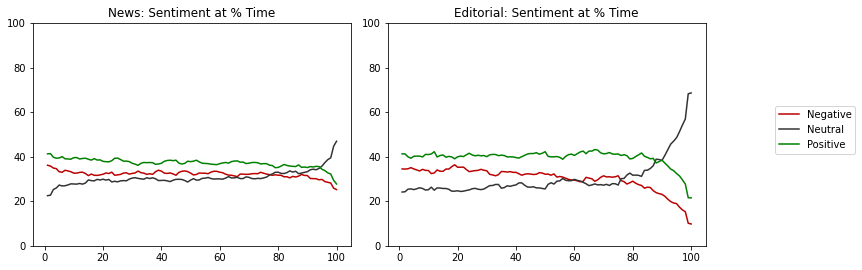

In [154]:
plot_normalized(news_norm_sent_df,edit_norm_sent_df,\
                'News: Sentiment at % Time','Editorial: Sentiment at % Time',\
                ["Negative",'Neutral',"Positive"],None,['#BB0000','#333333','green'])

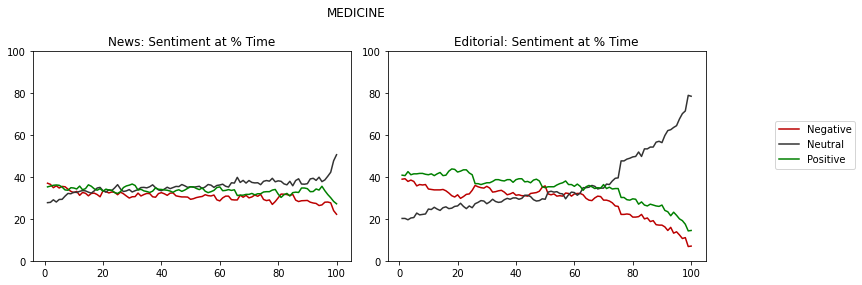

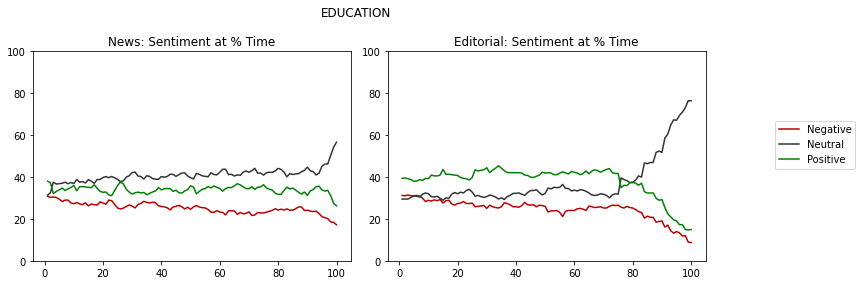

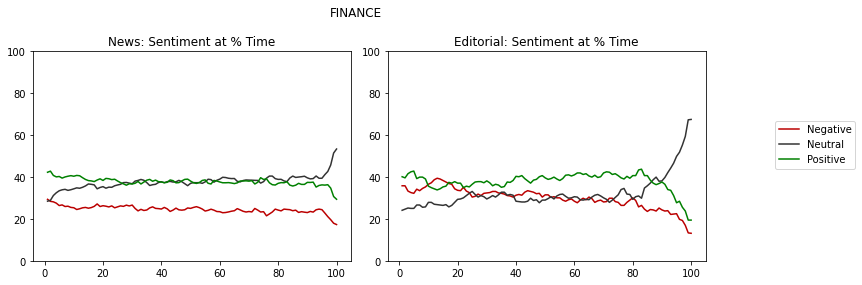

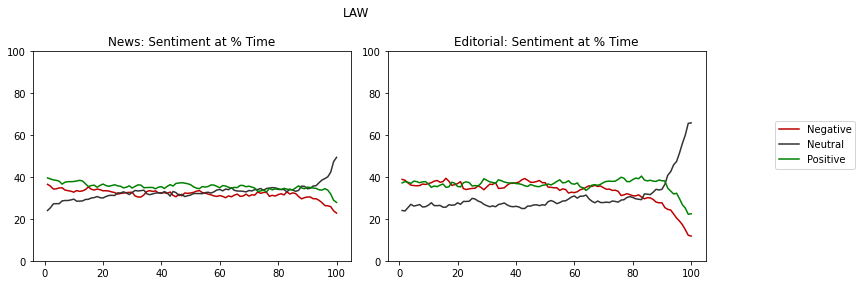

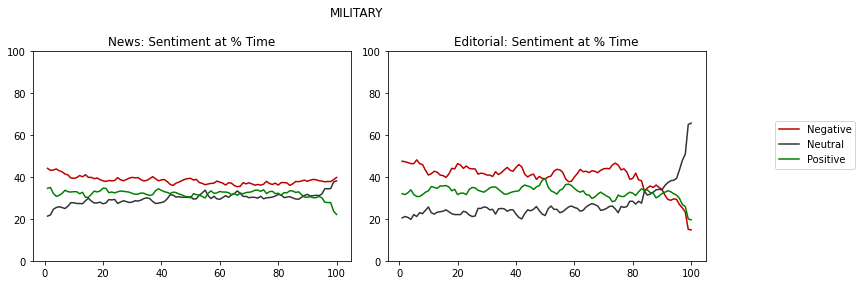

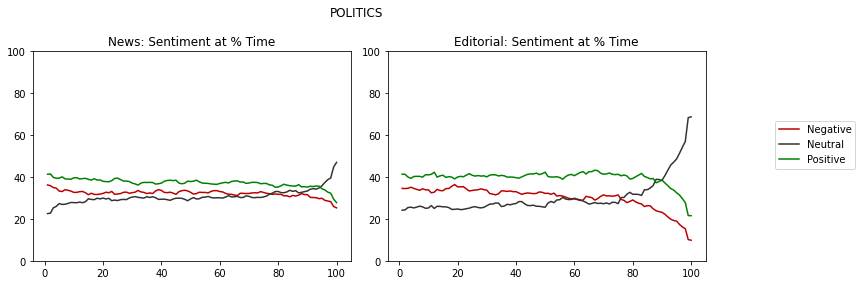

In [155]:
# report by genre
for idx,df in enumerate(list_of_dfs):
    
    filename = list_of_files[idx].split('_')[-1:]
    genre = filename[0].split('.')[0].upper()

    news_df, edit_df = get_normalizetimed_result(df,4)
    plot_normalized(news_df,edit_df,\
                'News: Sentiment at % Time','Editorial: Sentiment at % Time',\
                ["Negative",'Neutral',"Positive"],genre,['#BB0000','#333333','green'])

## 4.3 POS Tags

1. avg occurance in news vs edit
2. avg % occurance in news vs edit
3. correlation between each pos-tag and types of material

In [50]:
# Import reference for POS Tags
from nltk.data import load
nltk.download('tagsets')
tagdict = load('help/tagsets/upenn_tagset.pickle')
print(nltk.help.upenn_tagset())

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets to
[nltk_data]     /home/users/rldall/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [47]:
news_pos_result, edit_pos_result = get_features_result(all_df, 5)

print(sorted(news_pos_result.items(),key=operator.itemgetter(1),reverse=True))
print(sorted(edit_pos_result.items(),key=operator.itemgetter(1),reverse=True))

[('NN', 12.67), ('IN', 11.12), ('NNP', 9.72), ('DT', 9.43), ('JJ', 6.13), ('NNS', 5.97), (',', 5.4), ('VBD', 3.92), ('.', 3.86), ('RB', 3.21), ('VB', 3.0), ('PRP', 2.66), ('CC', 2.61), ('TO', 2.45), ('VBN', 2.29), ('VBZ', 1.92), ('CD', 1.87), ('VBG', 1.72), ('VBP', 1.54), ("''", 1.52), ('MD', 1.04), ('PRP$', 1.0), ('POS', 0.78), ('``', 0.62), ('WDT', 0.52), ('WP', 0.48), (':', 0.38), ('NNPS', 0.32), ('WRB', 0.31), ('JJR', 0.3), ('RP', 0.28), ('$', 0.25), ('JJS', 0.19), ('EX', 0.15), ('RBR', 0.14), ('RBS', 0.05), ('(', 0.05), (')', 0.05), ('PDT', 0.04), ('WP$', 0.03), ('FW', 0.01), ('UH', 0.01), ('#', 0.0), ('SYM', 0.0), ('LS', 0.0)]
[('NN', 12.94), ('IN', 10.85), ('DT', 9.43), ('NNP', 8.56), ('JJ', 7.09), ('NNS', 5.98), (',', 4.58), ('.', 4.32), ('RB', 3.89), ('VB', 3.75), ('CC', 2.9), ('TO', 2.7), ('PRP', 2.58), ('VBZ', 2.45), ('VBD', 2.43), ('VBN', 2.16), ('VBG', 1.74), ('VBP', 1.71), ('CD', 1.49), ('MD', 1.47), ('PRP$', 1.14), ('POS', 0.76), ("''", 0.66), (':', 0.58), ('WDT', 0.52),

In [110]:
count_dict_list = get_correlation(all_df,5)
pos_df = pd.DataFrame(count_dict_list).fillna(0)

In [119]:
corr_dict = {}

for col in pos_df.columns:
    corr = pos_df['y'].corr(pos_df[col])
    corr_dict.update({col:round(corr,2)})
    print('Correlation between editorials and {} is {}'.format(col,corr))
    
print('\nEditorial correlation result:\n',sorted(corr_dict.items(),key=operator.itemgetter(1)))

Correlation between editorials and JJ is -0.2771005393552578
Correlation between editorials and NNS is -0.3091230160905518
Correlation between editorials and VBG is -0.2973214840058606
Correlation between editorials and IN is -0.3449452678781854
Correlation between editorials and NNP is -0.35940416918959056
Correlation between editorials and . is -0.27795086242985606
Correlation between editorials and RB is -0.23423451564062245
Correlation between editorials and VBP is -0.22154564992777306
Correlation between editorials and DT is -0.3404553267051698
Correlation between editorials and NN is -0.32857537397294817
Correlation between editorials and TO is -0.29867928453526565
Correlation between editorials and VB is -0.24724733867513038
Correlation between editorials and MD is -0.17993710944020552
Correlation between editorials and JJR is -0.18416927783757847
Correlation between editorials and PRP$ is -0.20746824585272572
Correlation between editorials and CC is -0.2754637503668613
Correlat

In [58]:
for idx,df in enumerate(list_of_dfs):
    
    filename = list_of_files[idx].split('_')[-1:]
    genre = filename[0].split('.')[0].upper()
    print('Editorial correlation result for', genre)
    
    count_dict_list = get_correlation(df,5)
    pos_df = pd.DataFrame(count_dict_list).fillna(0)

    corr_dict = {}
    for col in pos_df.columns:
        corr = pos_df['y'].corr(pos_df[col])
        corr_dict.update({col:round(corr,2)})
    
    print(sorted(corr_dict.items(),key=operator.itemgetter(1)),'\n')

Editorial correlation result for MEDICINE
[('VBD', -0.46), ('NNP', -0.45), (',', -0.43), ('IN', -0.42), ('DT', -0.42), ('NN', -0.42), ('VBN', -0.41), ('NNS', -0.4), ("''", -0.4), ('VBG', -0.39), ('TO', -0.39), ('CC', -0.39), ('.', -0.38), ('CD', -0.38), ('JJ', -0.37), ('VB', -0.36), ('RB', -0.34), ('POS', -0.34), ('WDT', -0.34), ('``', -0.34), ('PRP', -0.33), ('MD', -0.32), ('WP', -0.32), ('VBP', -0.31), ('PRP$', -0.31), ('WRB', -0.3), ('VBZ', -0.29), ('JJR', -0.28), ('RP', -0.28), ('JJS', -0.26), ('EX', -0.24), ('RBR', -0.23), ('$', -0.23), ('NNPS', -0.22), (':', -0.19), ('RBS', -0.17), ('PDT', -0.16), ('WP$', -0.14), ('(', -0.05), (')', -0.05), ('FW', -0.05), ('UH', -0.05), ('#', -0.03), ('SYM', 0.03), ('y', 1.0)] 

Editorial correlation result for EDUCATION
[('VBD', -0.47), ('DT', -0.46), ('IN', -0.43), ('NN', -0.43), ('VBN', -0.43), ("''", -0.43), (',', -0.42), ('TO', -0.41), ('VBG', -0.4), ('NNS', -0.39), ('VB', -0.39), ('.', -0.39), ('POS', -0.39), ('JJ', -0.37), ('CC', -0.37), (

In [12]:
all_df[5][0][0]

0    [['JJ', 'NNS', 'VBG', 'IN', 'NNP', '.'], ['JJ'...
0    [['IN', 'JJ', 'NNS', ',', 'JJR', 'IN', 'DT', '...
0    [['PRP', 'VBD', 'NN', 'TO', 'VB', 'DT', 'NN', ...
0    [['IN', 'DT', 'NNP', 'CD', ',', 'CD', ',', 'NN...
0    [['RB', ',', 'EX', 'VBZ', 'NN', 'IN', 'DT', 'J...
0    [['NNP', 'VBZ', 'DT', 'JJ', 'NN', 'RB', ',', '...
Name: 5, dtype: object

In [21]:
from collections import Counter
from nltk import ngrams

In [65]:
def common_ngrams(df):
    news_counter = collections.Counter()
    edit_counter = collections.Counter()

    for _, row in df.iterrows():
        v = literal_eval(row[5])
        flatten = [item for sublist in v for item in sublist]
        ngram_counts = Counter(ngrams(' '.join(flatten).split(), 3))
        ngram_dict = dict(ngram_counts.most_common(10))
        
        if row[0] == 0 : #row=label; news: 0
            news_counter.update(ngram_dict)
        elif row[0] == 1 : #row=label; news: 0
            edit_counter.update(ngram_dict)

    return dict(news_counter), dict(edit_counter)

In [66]:
news_ngrams, edit_ngrams = common_ngrams(all_df)

In [67]:
print(news_ngrams)

{('IN', 'DT', 'NN'): 224179, ('DT', 'NN', 'IN'): 172598, ('NN', 'IN', 'DT'): 160999, ('VBD', 'DT', 'NN'): 4889, ('DT', 'NN', 'POS'): 2135, ('NN', '.', 'DT'): 1142, ('DT', 'NNP', '.'): 1368, ('IN', 'DT', 'NNP'): 52771, ('POS', 'NN', 'IN'): 46, ('NNS', 'VBN', 'IN'): 60, ('DT', 'JJ', 'NN'): 162714, ('JJ', 'NN', 'IN'): 64715, ('IN', 'DT', 'JJ'): 76975, ('NNS', 'VBP', 'VBN'): 181, ('NN', 'IN', 'NN'): 10707, ('VBN', 'IN', 'DT'): 3785, ('IN', 'JJ', 'NNS'): 11581, ('NNP', 'NNP', 'NNP'): 74211, ('IN', 'NNP', 'NNP'): 45618, ('NNP', 'NNP', ','): 87232, ('DT', 'NNP', 'NNP'): 28975, ('NN', 'IN', 'NNP'): 34638, ('MD', 'VB', 'DT'): 511, ('NN', 'IN', 'NNS'): 1438, ('JJ', 'NNS', 'VBD'): 123, ('DT', 'NN', 'NN'): 19417, ('IN', 'CD', 'NNS'): 398, (',', 'DT', 'NN'): 5706, ('NNP', ',', 'DT'): 7405, ('NN', 'NN', 'NN'): 439, ('JJ', 'NNS', 'IN'): 7155, ('PRP', 'MD', 'VB'): 2020, ('IN', 'NNP', 'IN'): 210, ('NNP', 'IN', 'PRP'): 4, ('IN', 'PRP', 'MD'): 42, ('DT', 'NN', 'VBD'): 6335, ('.', 'DT', 'NN'): 2677, ('NNS

In [68]:
print(edit_ngrams)

{('JJ', 'NN', 'NNS'): 414, (',', 'NNP', 'NNP'): 614, ('NNP', 'NNP', 'VBZ'): 427, ('DT', 'NN', 'IN'): 20848, ('NN', 'IN', 'NNP'): 3492, ('NNS', 'DT', 'NN'): 10, ('DT', 'JJ', 'NN'): 22467, ('IN', 'DT', 'NN'): 24342, ('NNS', 'CC', 'NN'): 15, ('CC', 'NN', 'NNS'): 43, ('NNP', 'NNP', ','): 4543, ('DT', 'NN', '.'): 1124, ('NN', 'IN', 'DT'): 18045, ('IN', 'NNP', 'NNP'): 4518, ('DT', 'NN', 'CC'): 86, ('NNP', 'NNP', 'NNP'): 9293, ('NN', 'CC', 'NN'): 492, ('IN', 'CD', 'NN'): 40, ('IN', 'VBN', 'NN'): 12, ('VBN', 'IN', 'DT'): 755, ('NN', 'NN', '.'): 255, ('NN', 'NN', 'NN'): 140, ('VBN', 'NN', 'NN'): 2, ('NNP', ',', 'NNP'): 1878, ('DT', 'NN', 'VBZ'): 748, ('NN', 'VBZ', 'IN'): 36, ('JJ', 'NN', '.'): 2785, ('IN', 'DT', 'JJ'): 10437, ('JJ', 'NN', 'IN'): 10169, ('NN', '.', 'NNP'): 248, ('MD', 'VB', 'VBN'): 378, ('JJ', 'JJ', 'NNS'): 267, ('DT', 'JJ', 'NNS'): 443, ('DT', 'NN', 'VBD'): 347, ('NN', 'VBD', 'VBN'): 44, ('DT', 'NN', ','): 1110, ('NN', ',', 'NNS'): 9, ('.', 'DT', 'NN'): 889, ('NNS', '.', 'DT'):